<a href="https://colab.research.google.com/github/pushyag1/DeepLearningClass/blob/master/Chapter_7_Auto_Encoding_and_Self_Supervision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time


from google.colab import drive
drive.mount('/content/gdrive/')
import sys
sys.path.append('/content/gdrive/My Drive/MPDL Fall 2020/')

from mpdl import train_network, Flatten, View, weight_reset,  set_seed

Mounted at /content/gdrive/


In [ ]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

from IPython.display import display_pdf
from IPython.display import Latex

In [ ]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

At this point we have learned about a number of different approaches to specifying a neural network, and we have done this for classification and regression problems. There are the classic machine learning problems, where for each data point $\boldsymbol{x}$ we have an associated answer $y$. But what if we do not have a label $y$? Is there any useful way for us to learn? You should recognize this as an _unsupervised_ learning scenario. 

You should be interested in self-supervision because _labels are expensive_. It is often much easier to get lots of data, but knowing _what_ each data point is requires a lot of work! Think about a sentiment classification problem where you might try to predict if a sentence is conveying a positive notion (e.g., "I love this deep learning book I'm reading!") or a negative one (e.g., "the author of this book is really bad at making jokes"). It's not _hard_ to read the sentence, make a determination, and save that information. But if you want to build a _good_ sentiment classifier, you might want hundreds of thousands to millions of sentences labeled! Do you really want to spend days or weeks labeling so many sentences? If we could somehow learn without needing these labels, it would make our lives much easier!

One strategy for unsupervised learning that has become increasingly common within deep learning is called _self-supervision_. The idea behind self-supervision is that we will use a regression or classification loss function $\ell$ to do the learning, and we will predict something about the input data $\boldsymbol{x}$ itself! In these cases the labels come _implicitly with the data_, and allow us to use the same tools we have already learned to use. The below figure shows some of the ways self supervision could be done. 

![Three different types of self-supervised problems that could be constructed. In each case, we do not need to know _what_ the image is of, because the network will try to predict the original image no matter what. The first case (red) we randomly block out a portion of the image, and ask the network to fill in the missing piece. The second case we break the image up into pieces and shuffle them, and ask the network to put them back in the correct order. The last case we simply ask the network to predict the original image from the original image!](https://drive.google.com/uc?export=view&id=1AUEi3B5l5Q6YDRX792-q42t8T9IUX2BX)


There are numerous ways to create a self-supervised problem, and researchers are coming up with new approaches all the time. We are going to focus on one specific kind of self-supervision called _auto encoding_. The third example from the above figure is actually an auto encoding one, because the key to auto encoding is _predicting the input from the input_! This may seem like an insane idea at first. Surely this is a trivial problem for the network, simply learn to return the input! This would be like defining a function as:

```python
def superUsefulFunction(x):
    return x
```

This `superUsefulFunction` would implement a _perfect_ auto encoder. So if the problem is so easy, how could it actually be useful? Thats what we will learn in this chapter. The trick is to _constrain_ the network, giving it a handicap so that it is unable to learn the trivial solution. With the trivial solution off the table, the network is forced to learn something more useful in order to solve the problem. 

# Principle Component Analysis and Auto Encoding

Lets first describe the idea of auto-encoding in a little more detail. Auto-encoding means that we generally learn _two_ functions/networks. First, a function $f^{\mathit{in}}(\boldsymbol{x})=\boldsymbol{z}$, which transforms the input $\boldsymbol{x}$ into a new representation $\boldsymbol{z} \in R^{D'}$. Next a function $f^{\mathit{out}}(\boldsymbol{z}) = \boldsymbol{x}$, which converts the new representation $\boldsymbol{z}$ back to the original representation! We call these two functions the _encoder_ $f^{\mathit{in}}$ and the _decoder_ $f^{\mathit{out}}$.

This may seem very silly at first glance. Couldn't we just learn a function $f^{\mathit{in}}$ that does not do anything, and returns the input as output? Then we can trivially solve the problem! This is the dangerous short-cut that we want to avoid. The trick then, is to set up the problem in such away that the network can't cheat like this. There are a number of different approaches to doing this, that we will describe in this lecture. 

Now you have probably heard of the feature engineering and dimensionality reduction technique known as Principle Component Analysis (PCA). PCA is used to convert a feature vector in a $D$ dimensional space down to a lower dimension $D'$, which one might call an _encoder_. PCA also includes a _decoder_ step, where you can convert back to the original $D$ dimensional space! If you are starting to think that PCA might be an auto encoding algorithm, you are correct! In fact, the below equation defines the optimization problem that PCA solves. 

$$ \underset{W}{\text{minimize}} \lVert \mathbf{X} - \mathbf{X} W W^T \lVert_2^2 $$
$$ \text{subject to }  W^T W = I$$

PCA is an important and widely used algorithm, so if you want to use it - you should use one of the existing implementations. But PyTorch is flexible enough for us to implement PCA ourselves. If you look closely at equation, PCA is a _regression_ problem. How? Lets look at the main part of the equation, and try and annotate it. 

$$\lVert \underbrace{\mathbf{X}}_{\text{label } y \in R^D} - \overbrace{\mathbf{X} \underbrace{W}_{\text{encoder}} \underbrace{W^T}_{\text{decoder}}}^{f(X)} \lVert_2^2$$

So we have one weight matrix acting as the encoder, and it's transpose is acting as the decoder. So that means PCA is using _weight sharing_ (remember that concept from Chapters 3 and 4?). The original input is on the left, and we have the 2-norm ($\|\cdot\|^2_2$) which is used by the mean squared error loss. The "subject to" part of the equation is a _constraint_, requiring the weight matrix to behave in a particular way.  Lets right re-write this equation in the same manner that we have been doing for our neural networks. We use 

$$\sum_{i=1}^n \ell\left(f(\boldsymbol{x}_i), \underbrace{\boldsymbol{x}_i}_{\boldsymbol{y}_i}\right) + R(W)$$

Where $R$ is a regualization penalty based on the "subject to" constraint before. So we will use:

$$R(W) = \| W W^T - I \|_2^2$$

Second, we need to define our network function $f(x)$, which is simply:

$$f(\boldsymbol{x}) = \boldsymbol{x} \underbrace{W}_{\text{nn.Linear(}D, D')} W^T$$

Now we have written our PCA as a loss function over all our data points! We know PCA works, and if PCA is an auto encoder then the idea of auto encoding can't be as crazy as it first seems. So how does PCA make it work? The insight that PCA provides is that we make the _intermediate representation too small_. Remember that the first thing PCA is doing is going from $D$ dimensions down to $D' < D$. Image if $D=1,000,000$ and $D'=2$. There is just _no possible way_ that you are going to be able to save enough information about 1 million features in just 2 features to be able to reconstruct the input perfectly. So the best that PCA can do is to learn the best 2 features it can, which then forces PCA to learn something useful! This is the primary trick people use to make  auto-encoding work, push your data into a smaller representation than they started. 

Now lets walk through actually implementing PCA. The main trick we need to implement this is to re-use the weight from a linear layer inside of PyTorch. Well walk through actually implementing PCA in PyTorch now to hammer home the fact that _PCA is an auto encoder_ and then build on that foundation. 



In [ ]:
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 28*28 #28 * 28 images 
#Hidden layer size
n = 2 
#How many channels are in the input?
C = 1
#How many classes are there?
classes = 10

We will call this new layer we need a _transpose layer_. Why? Because the mathematical operation we are using is called a transpose! We will also add some logic to have a custom bias term for the weight transposed layer as well. This is done because the input layer has a matrix with shape $W \in R^{D \times D'}$, and a bias vector $\boldsymbol{b} \in R^{D'}$. That means $W^T \in R^{D' \times D}$, but we can't really take a meaningful transpose of $\boldsymbol{b}$. So if someone wants a bias term, it will have to be a new separate one. So our new `TransposeLinear` module is below.

In [ ]:
class TransposeLinear(nn.Module): #Our class extends nn.Module, all PyTorch layers must extend this! 
    def __init__(self, linearLayer, bias=True):
        """
        linearLayer: is the layer that we want to use the transpose of as the output of this 
            layer. So the Linear layer represents W, and this layer represents W^T. This is 
            acomplished via weight sharing by re-using the weights of linearLayer
        bias: if True, we will crease a new bias term b that is learned seperatly from what 
            is in linearLayer. If false, we will not use any bias vector. 
        """
        super().__init__()
        
        #We create a new variable weight to store a _reference_ to the original weight term. 
        self.weight = linearLayer.weight
        if bias:
            #We need to create a new bias vector. By default, pyTorch knows how to update Modules and Parameters. 
            #Since tensors are not either, the Parameter class wraps the Tensor class, so that pyTorch knows that 
            #the values in this tensor need to be updaded by gradient descent
            self.bias = nn.Parameter(torch.Tensor(linearLayer.weight.shape[1]))
        else:
            #The Parameter class can not take None as an input. So if we want the bias term to exist, but be 
            #potentially unused, we can use the register_parameter function to create it. The important thing 
            #here is that PyTorch always sees the same paramters regardless of what we set the arguments for the 
            #Module are. 
            self.register_parameter('bias', None)
    
    #The forward function is the code that takes an input and produce an output. 
    def forward(self, x):
        #The F director of cuntion contains many _functions_ that are used by Modules. For example, the linear function 
        #performs a linear transform when given an input (we use the transpose of our weights) and a bias (if None, it
        #knows) to not do anything 
        return F.linear(x, self.weight.t(), self.bias)

Now that we have our `TransposeLinear` layer completed, we can implement PCA! First is the architecture, which we break apart into the encoder and decoder portions. Because PyTorch `Module`s are also built from `Modules`, we can define the encoder and decoder as separate parts, and use both as  components in a final `Module`. 

Note that because the input comes in as an image with shape $(\boldsymbol{B}, 1, 28, 28)$, and we are using linear layers, we first need to flatten it into a vector of shape $(\boldsymbol{B}, 28*28)$. But in the decode step, we want to have the same shape as the original data. We can use the `View` layer I've provided to convert it back. It works just like the `.view` and `.reshape` functions on tensors, except as a `Module` for convenience. 

In [ ]:
#Since we will share the weights of the linear layer, lets define it separately
linearLayer = nn.Linear(D,  n, bias=False)
#The encoder just falltens and then uses the linear layer
pca_encoder = nn.Sequential(
    nn.Flatten(),
    linearLayer,
)
#The decoder uses our TransposeLinear layer + the now shared linearLayer object 
pca_decoder = nn.Sequential(
    TransposeLinear(linearLayer, bias=False),
    View(-1, 1, 28, 28)#Shape the data back to it's original form
)
#Define a final PCA model that is the sequence of an encoder, followed by a decoder
pca_model = nn.Sequential(
    pca_encoder,
    pca_decoder
)

Now we have everything we need to train up this auto encoder! But to make it _truly_ PCA we need to add this $W W ^\top = I$ constraint. This constraint has a particular name, and its called _orthogonality_. We are not going to go into the derivation of _why_ PCA has this, but we want to include it as a good exercise.  First we will start our model off in the right place by giving it an initial _random_ set of orthogonal weights using the `nn.init.orthogonal_` function. That just takes one line of code:

In [ ]:
nn.init.orthogonal_(linearLayer.weight)

Parameter containing:
tensor([[-0.0063, -0.0112, -0.0474,  ...,  0.0428,  0.0234, -0.0159],
        [-0.0503,  0.0659, -0.0364,  ...,  0.0330,  0.0096,  0.0341]],
       requires_grad=True)

We aren't going to strictly enforce orthogonality during training because the code to do that would be a little uglier than I want. Instead we will take a common and simple approach to _encourage_ orthogonality but not _require_ it. This is done by converting the equality $W^T W = I$ into a _penalty_ or _regularizer_ $\|W W^\top - I\|^2_2$. This works because if the penalty is 0, then $W$ is orthogonal, and if it is non-zero, it will increase the loss, and thus gradient decent will try to make $W$ more orthogonal! 

It is not hard to implement this. We are using the mean square error (MSE) loss function $\ell_{\mathit{MSE}}(f(\boldsymbol{x}),\boldsymbol{x})$ to train the self-supervision part. We can just augment this loss function with the loss over the penalty, becoming:

$$\ell_{\mathit{MSE}}(f(\boldsymbol{x}),\boldsymbol{x}) + \ell_{\mathit{MSE}}(W W^\top,\boldsymbol{I})$$

The below block of code will do this. As an additional step, we'll decrease the strength of the regularizer by a factor of $0.1$ just to reinforce that the auto encoding portion is more important than the orthogonality portion. 

In [ ]:
mse_loss = nn.MSELoss() #Original loss function

def mseWithOrthoLoss(x, y):#our PCA loss function
    #Grabing W from the linearLayer object we saved earlier. 
    W = linearLayer.weight
    #The identity matrix that is the target for the regularized
    I = torch.eye(W.shape[0]).to(device)
    #compute the original loss $\ell_{\mathit{MSE}}(f(\boldsymbol{x}), \boldsymbol{x})$
    normal_loss =  mse_loss(x, y) 
    #compute the regularizer penalty $\ell_{\mathit{MSE}}(W^\top W, \boldsymbol{I})$
    regularization_loss = 0.1*mse_loss(torch.mm(W, W.t()), I)
    #return the sum of the two losses
    return normal_loss + regularization_loss

Now we want to create a wrapper for the MNIST datasets. Why? Because the default MNIST dataset will return data in pairs $(\boldsymbol{x}, y)$ for the input and label respectively. But in our case, the _input is the label_, because we are trying to predict the input from the input! So we will extend the PyTorch `Dataset` class to take the original tuple $\boldsymbol{x}, y$, and instead return a tuple $\boldsymbol{x}, \boldsymbol{x}$. This way our code keeps the convention that the first item in the tuple is the input, and the second item is the desired output / "label". 

In [ ]:
class AutoEncodeDataset(Dataset):
    """Takes a dataset with (x, y) label pairs and converts it to (x, x) pairs. 
    This makes it easy to re-use other code"""

    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset.__getitem__(idx)
        return x, x#just throw away the original label. 

If you were implementing an auto encoder for a real world problem, you would have code that looks more like `x = self.dataset.__getitem__(idx)` instead, because you don't actually know the label `y`! Then you could `return x, x` after. 

With this `AutoEncodeDataset` wraper in hand we can go ahead and load up the original MNIST dataset, wrap it with `AutoEncodeDataset`, and be ready to start training! 

In [ ]:
train_data = AutoEncodeDataset(torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True))
test_data_xy = torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)
test_data_xx = AutoEncodeDataset(test_data_xy)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data_xx, batch_size=128)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Now we can train this PCA model the same way we have been training other neural networks! 

In [ ]:
train_network(pca_model, mseWithOrthoLoss, train_loader, val_loader=test_loader, epochs=10, device=device)

,epoch,total time,train loss,val loss
0,0,5.313424,0.064729,0.058338
1,1,10.932399,0.058283,0.057942
2,2,16.299867,0.057916,0.057815
3,3,21.721643,0.057886,0.057859
4,4,27.223123,0.057888,0.057859
5,5,32.537948,0.057886,0.057824
6,6,37.902255,0.057890,0.057810
7,7,43.265132,0.057888,0.057846
8,8,48.719906,0.057888,0.057845
9,9,54.129663,0.057889,0.057802


You make have noticed we used the hidden layer size $n=2$. This was intentional, because it lets us _plot_ the results and build some good visual intuition about how auto encoders work!  This is because can use PCA to visualize our data in two dimensions when $n=2$. This is a very common use case for PCA. Even if we used a larger target dimension, projecting the data down can make it faster and/or more accurate to search for similar data. So it is useful to have a function that will take a dataset and encode it all to the lower dimensional space. The below function will do that, and also copy the labels so that we can look at our results compared to the ground truth of the MNIST test data. 

In [ ]:
def encode_batch(encoder, dataset_to_encode):
    """
    encoder: the PyTorch network that takes in a dataset and convers it to a new dimension
    dataset_to_encode: a PyTorch `Dataset` object that we want to convert. 

    Returns a tuple (projected, labels) where `projected` is the encoded version of the dataset, and `labels` are the original labels provided by the `dataset_to_encode`
    """
    #Create space to store the results
    projected = []
    labels = []
    #Switch to eval mode
    encoder = encoder.eval()
    #Switching to CPU mode for simplicty, but you don't have to. 
    encoder = encoder.cpu()
    with torch.no_grad():#We don't want to train, so torch.no_grad! 
        for x, y in  DataLoader(dataset_to_encode, batch_size=128):
            z = encoder(x.cpu()) #encode the original data
            projected.append( z.numpy() ) #store the encoded version & label
            labels.append( y.cpu().numpy().ravel() )
    #Turn the results into single large numpy arrays
    projected = np.vstack(projected)
    labels = np.hstack(labels)
    #return the results
    return projected, labels
#Now lets project our data!
projected, labels = encode_batch(pca_encoder, test_data_xy)

Using the `encode_batch` function we have now applied PCA to the dataset, and below we can plot the results with seaborn. This should look like a very familiar PCA plot! We can see that some classes have decent separation from the others, while some are clumped together. 

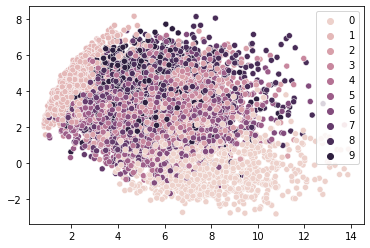

In [ ]:
sns.scatterplot(x=projected[:,0], y=projected[:,1], hue=labels, legend="full")

From this plot we can get some ideas about the quality of the encoding. For example, its probably easy to differentiate the 0 and 1 class from all the others. Some of the others might be much harder though. Another thing we can use to help us judge this is the encode and decode process itself! If we did a good job, the output should be the same as the input. Fist well define a simple helper function to plot the original input $\boldsymbol{x}$ on the left. and the encoded-decoded version on the right. 

In [ ]:
def showEncodeDecode(encode_decode, x):
    """
    encode_decode: the PyTorch Module that does the encoding and decoding steps at once
    x: the input to plot as is, and after encoding & decoding it
    """
    #Switch to eval mode
    encode_decode = encode_decode.eval()
    #We will move things to the CPU so that we don't have to think about what device anything was on
    #and because this functino is not performance sensative
    encode_decode = encode_decode.cpu()
    with torch.no_grad():#Always no_grad if you are not training! 
        x_recon = encode_decode(x.cpu())
    #Use matplotlib to create a size-by-side plot with the original on the left
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(x.numpy()[0,:])
    axarr[1].imshow(x_recon.numpy()[0,0,:])

We will re-use this function throughout this chapter. First lets look at some input-output combinations for a few different digits. 

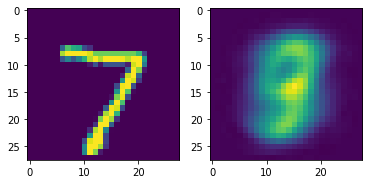

In [ ]:
showEncodeDecode(pca_model, test_data_xy[0][0])

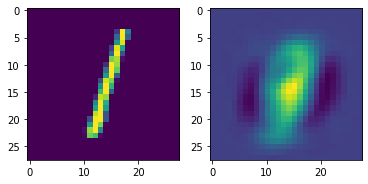

In [ ]:
showEncodeDecode(pca_model, test_data_xy[2][0])

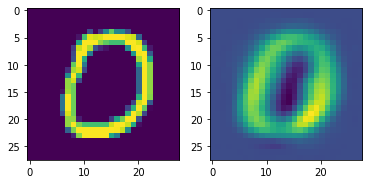

In [ ]:
showEncodeDecode(pca_model, test_data_xy[10][0])

The above results match what we expected based on the 2D plot. The 0 and 1 classes look kinda like a 1 and zero after we encode and decode them. The seven... not so much. Why? Well, we are converting 784 dimensions down to 2. Thats a _lot_ of information compression! Much more than we can reasonably expect poor PCA to be able to do. 

But PCA is one of the simplest auto-encoders we could design, because it is a completely linear model! What happens if we just add a little bit of what we have learned about? We can add just a single non-linearity and remove the weight sharing to turn this into a small non-linear auto-encoder. Lets see how that looks. 

In [ ]:
#First the encoder is augmented by a Tanh non-linearity
pca_nonlinear_encode = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D,  n),
    nn.Tanh(),
)
#The decoder gets its own Linear layer now, making it look more like a normal network
pca_nonlinear_decode = nn.Sequential(
    nn.Linear(n, D),
    View(-1, 1, 28, 28)
)
#Combine then together into the encoder-decoder function $f(\cdot)$
pca_nonlinear = nn.Sequential(
    pca_nonlinear_encode,
    pca_nonlinear_decode
)

Since we are not sharing weights between the encoder and decoder any more, we do not care if the weights are orthogonal either. So when we train this model we will just use the normal MSE loss. 

In [ ]:
train_network(pca_nonlinear, mse_loss, train_loader, val_loader=test_loader, epochs=10, device=device)

,epoch,total time,train loss,val loss
0,0,5.392306,0.132143,0.070279
1,1,10.862759,0.066716,0.065920
2,2,16.313393,0.065426,0.065247
3,3,21.697814,0.064543,0.064036
4,4,26.959295,0.062945,0.062035
5,5,32.282162,0.060776,0.059980
6,6,37.800889,0.059151,0.058815
7,7,43.146605,0.058259,0.058132
8,8,48.462235,0.057759,0.057744
9,9,53.775755,0.057452,0.057515


In the below blocks of code well again plot all the 2d encodings and our three encoded-decoded images to see visually what has changed.  This lets us subjectively look to see if the quality is better. 

In [ ]:
projected, labels = encode_batch(pca_nonlinear_encode, test_data_xy)

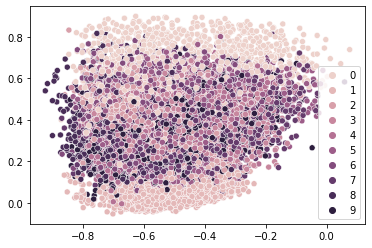

In [ ]:
sns.scatterplot(x=projected[:,0], y=projected[:,1], hue=labels, legend="full" )

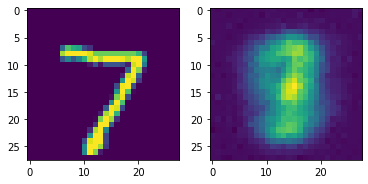

In [ ]:
showEncodeDecode(pca_nonlinear, test_data_xy[0][0])

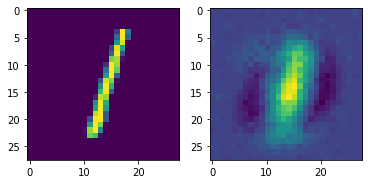

In [ ]:
showEncodeDecode(pca_nonlinear, test_data_xy[2][0])

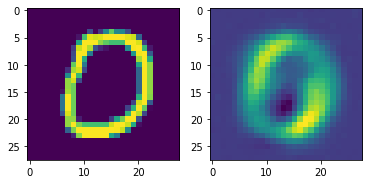

In [ ]:
showEncodeDecode(pca_nonlinear, test_data_xy[10][0])

Overall the improvement is small but noticeable! The 2D plot still has a lot of overlap, but but we can see some more separation between all ten classes (the "0" class isn't dominating all of the space any more). While the encode-decode images show a few artifacts, the "0" and "1" are more distinctly "0" and "1". But its still hard to tell what is going on with the "7". 

# Auto-Encoding Networks

PCA is a very popular method for dimensionality reduction and visualization, and any situation where you would want to use PCA is one where you may want to instead use an auto-encoding _network_. An auto encoding network is the same idea, but we are going to make the encoder and decoder larger networks with more layers so that they can learn more powerful and complex encoders and decoders.  Since we have seen that PCA is an an auto-encoder, an auto-encoding network may be a more accurate alternative choice by being able to learn more complex functions. Auto-encoding networks are also useful for _outlier detection_. You want to detect outliers so that you can have them naturally reviewed, because an outlier is unlikely to be handled well by a model. An auto-encoder can detect outliers by looking at how well it reconstructed the input. If you can reconstruct the input well, the data probably looks like normal data that you've seen before. If you can _not_ successfully reconstruct the input, it is probably an _unusual_ input and thus an outlier! 


Now lets talk about specifically how to set up a deep learning based auto encoder. The standard approach that people use is to make a symmetric architecture between the encoder and decoder. So we will keep the same number of layers in each, and put them in the reverse order. In addition to being symmetric, we will also use a _bottle neck_ style encoder, meaning the layers will have progressively fewer and fewer neurons. 

![Example of a standard auto-encoder design. The input comes in on the left. The encoder starts our large, and tapers down the size of the hidden layers at each step. Because auto-encoders are usually symmetric, that means our decoder will receive the small representation $\boldsymbol{z}$ and start expanding it back out to the original size.  ](https://drive.google.com/uc?export=view&id=1VPDNUGCYtiF3WF_0UkmStQsb36dwrCFb)

Auto encoders do not _have_ to be symmetric. They will work _just fine_ if they are not! This is done purely to make it easier to think about and reason about the network. This way you are only making half as many decisions about how many layers in the network, how many neurons in each layer, and so on. 

The bottle neck in the encoder _is_ important though. Just the same as PCA did, by pushing down to a smaller representation we make it impossible for th network to "cheat" and learn the naive solution of immediately returning the input as the output! Instead the network must learn to identify high level concepts like "there is a circle located at the center", which could be used for encoding (and then decoding) the numbers "6" and "0". By learning multiple high level concepts, the network is forced to start learning useful representations. 

Since we have gone through the pain of implementing PCA, you should hopefully find the auto encoder easier and more straight forward when done in this style. Primarily because we do not share any weights across layers now, and we no longer need the orthogonal constraint on the weights. 

The below code shows just how easy it is to implement an auto encoder using the more advanced tools we have learned about like batch normalization and ReLU activations. It uses a simple strategy of decreasing the number of neurons in each hidden layer by a fixed pattern. In this case I'm dividing the number of neurons by 2, then 3, then 4, and so on until the last layer of my decoder were I jump straight to the target size $D'$. 

In [ ]:
#Dividing by 2, 3, 4, is one of many patterns that could have been used!
auto_encoder = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D,  D//2),
    nn.BatchNorm1d(D//2),
    nn.ReLU(),
    nn.Linear(D//2,  D//3),
    nn.BatchNorm1d(D//3),
    nn.ReLU(),
    nn.Linear(D//3,  D//4),
    nn.BatchNorm1d(D//4),
    nn.ReLU(),
    nn.Linear(D//4,  n), #Jump down to the target dimension
)

#Decoder will do the same layers/sizes in reverse now to be symmetric 
auto_decoder = nn.Sequential(
    nn.Linear(n,  D//4),
    nn.BatchNorm1d(D//4),
    nn.ReLU(),
    nn.Linear(D//4,  D//3),
    nn.BatchNorm1d(D//3),
    nn.ReLU(),
    nn.Linear(D//3,  D//2),
    nn.BatchNorm1d(D//2),
    nn.ReLU(),
    nn.Linear(D//2,  D),
    View(-1, 1, 28, 28) #Reshape to match the original shape
)
#Combine into a deep auto encoder!
auto_encode_decode = nn.Sequential(
    auto_encoder,
    auto_decoder
)

As always we can train this network using the exact same function, and well stick with the mean squared error which is very common in auto encoders. 

In [ ]:
train_network(auto_encode_decode, mse_loss, train_loader, val_loader=test_loader, epochs=10, device=device)

,epoch,total time,train loss,val loss
0,0,8.324499,0.049894,0.043093
1,1,16.285430,0.043232,0.040962
2,2,24.279737,0.041810,0.040552
3,3,32.460272,0.041011,0.039421
4,4,40.503696,0.040305,0.038720
5,5,48.445694,0.039715,0.038430
6,6,56.502292,0.039238,0.037792
7,7,64.422773,0.038951,0.037724
8,8,72.532834,0.038497,0.037048
9,9,80.950638,0.038336,0.037119


So how did our new auto-encoder do? If we look at the 2D plot below, we can see _much_ more separation in the projected dimension $z$! Classes "0", "6", and "3" are _very_ well separated from all the others! In addition, the middle area where there are more classes right next to each other at least has more continuity and uniformity in the class present.We can see that the classes have distinct "homes" within the middle area, rather than being smeared on top of each other. 

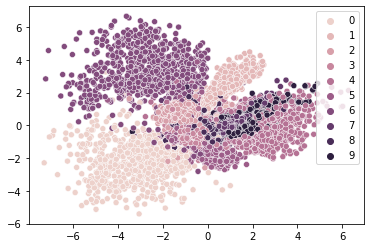

In [ ]:
projected, labels = encode_batch(auto_encoder, test_data_xy)
sns.scatterplot(x=projected[:,0], y=projected[:,1], hue=labels, legend="full")

This is also one way you can use auto-encoders for some exploration of unknown data. If we did not know the class labels, we could have concluded from this projection that there were likely at least 2-4 different sub-population within the data! 

We can also look at some examples of the encode-decode cycle below. Unlike before, the reconstructions are now crisp, with much less blur. Though its not perfect, the class 4 is usually hard to separate from others, and has low quality reconstructions. Beyond the examples shown below, try playing with the code and looking at the results for different data points. 

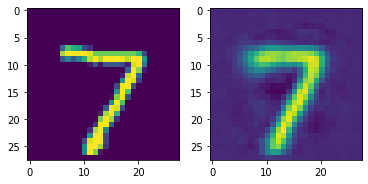

In [ ]:
showEncodeDecode(auto_encode_decode, test_data_xy[0][0])

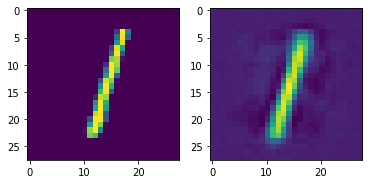

In [ ]:
showEncodeDecode(auto_encode_decode, test_data_xy[2][0])

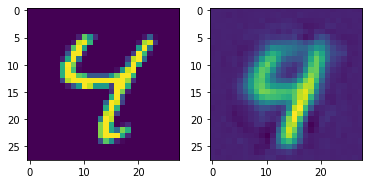

In [ ]:
showEncodeDecode(auto_encode_decode, test_data_xy[6][0])

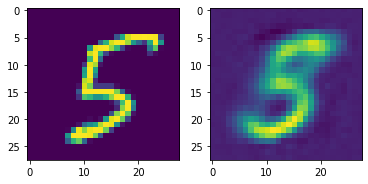

In [ ]:
showEncodeDecode(auto_encode_decode, test_data_xy[23][0])


If you do, you may start to notice that the reconstructions do not always maintain the _style_ of the inputs. This is more obvious with the 5 above. The reconstruction is actually smoother and more "pristine" than the original input! Is this a good thing or a bad thing? 

From the perspective of how we trained the model, its a bad thing. The reconstruction _is different_ from the input, and the goal was to _exactly_ reconstruct the input. 

However, our true goal is not to just learn to reconstruct inputs from themselves. We already have the input. Our goal was to learn a useful representation of the data, without needing to know the labels of the data. From this perspective, the behavior is a good thing. It means there are multiple different potential "fives" that could be the input, and would be mapped to the same "five" reconstruction. In this sense, the network has on its own learned that there is a _canonical_ or _prototypical_ 5, without being explicitly told about the concept of 5, or that there are even distinct numbers present. 

However, the example of the digit "4" above is a bad failure case. The network reconstructed a completely different digit! This is because the network has _too strong_ a restriction by being forced down to just 2 dimensions, and can't fully learn all of the complexity in the data with such little space. This has meant forcing out the concept of a "4". 

# Bigger Auto Encoders

All of the auto-encoding we have done so far has been based on projecting down to 2 dimensions, which we have already said is making the problem exceptionally hard! Your intuition should tell you that if we made the target dimension size $D'$ a little larger, our reconstructions should improve in quality. But what if we made the target size _larger_ than the original input? Would this work? We can easily modify our auto-encoder to try this and see what happens! In the below block of code I've simply jumped up to $D' = 2 \cdot D$ right after the first layer of the encoder, and stayed at that number of neurons for the entire process. 

In [ ]:
auto_encoder_big = nn.Sequential(
    Flatten(),
    nn.Linear(D,  D*2),
    nn.BatchNorm1d(D*2),
    nn.ReLU(),
    nn.Linear(D*2,  D*2),
    nn.BatchNorm1d(D*2),
    nn.ReLU(),
    nn.Linear(D*2,  D*2),
    nn.BatchNorm1d(D*2),
    nn.ReLU(),
    nn.Linear(D*2,  D*2),
)

auto_decoder_big = nn.Sequential(
    nn.Linear(D*2,  D*2),
    nn.BatchNorm1d(D*2),
    nn.ReLU(),
    nn.Linear(D*2,  D*2),
    nn.BatchNorm1d(D*2),
    nn.ReLU(),
    nn.Linear(D*2,  D*2),
    nn.BatchNorm1d(D*2),
    nn.ReLU(),
    nn.Linear(D*2,  D),
    View(-1, 1, 28, 28)
)

auto_encode_decode_big = nn.Sequential(
    auto_encoder_big,
    auto_decoder_big
)

In [ ]:
train_network(auto_encode_decode_big, mse_loss, train_loader, val_loader=test_loader, epochs=10, device=device)

,epoch,total time,train loss,val loss
0,0,8.075713,0.024393,0.013424
1,1,16.148528,0.013057,0.010279
2,2,24.243566,0.010517,0.009893
3,3,32.386615,0.009530,0.007922
4,4,40.598600,0.008594,0.007388
5,5,48.594667,0.008248,0.007931
6,6,56.706147,0.007607,0.006810
7,7,64.671096,0.007218,0.006575
8,8,72.807979,0.006897,0.006010
9,9,81.120246,0.006515,0.006051


We can't make a 2D plot since we have too many dimensions. But we can still do the encode/decode comparisons on the  data  to see how our new auto encoder performs. If we plot some examples, it becomes clear that we now have _very good_ reconstructions, which include even minute details from the original input. For example, the below 7 has a slight uptick at the top left, and slightly thicker ending at the bottom, which are present in the reconstruction. The "4" that was completely mangled previously has a lot of unique curve and style to it that are also faithfully preserved. 

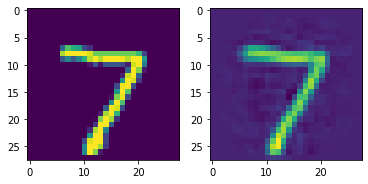

In [ ]:
showEncodeDecode(auto_encode_decode_big, test_data_xy[0][0])

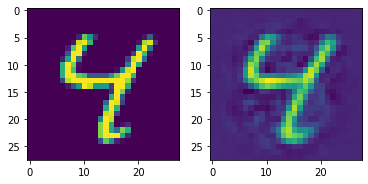

In [ ]:
showEncodeDecode(auto_encode_decode_big, test_data_xy[6][0])

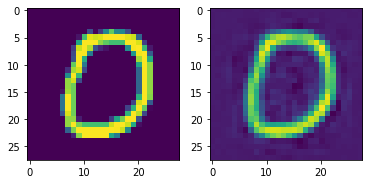

In [ ]:
showEncodeDecode(auto_encode_decode_big, test_data_xy[10][0])

So the question is, is this a better auto-encoder than the previous one? Have we learned a useful representation? Its a hard question to answer because we are using the input reconstruction as the loss of the network, but it not what we truly care about! We want the network to learn _useful_ representations. This is a variant of the classic unsupervised learning problem: if you don't know what you are looking for how do you know if you are doing a good job? 

## Robustness to Noise

To help us answer this question about which auto-encoder is better, $D'=2$ or $D'=2\cdot D$, we will add some noise to our data. Why? One intuition that we can use is that if a representation is good, it should be _robust_. Imagine if the clean data we have been using was like a road, and our model was the car. If the road is pristine and smooth, it is easy for the car to drive and handle well. But what if there are potholes and cracks (read, "noise") in the road? A good car should still be able to drive successfully. Similarly, if we have noisy data, an ideal model will still perform well!

There are _many_ different ways we could make our data noisy. One of the easiest is to add noise from a Normal distribution. We denote the Normal distribution as $N(\mu, \sigma)$, where $\mu$ is the the mean value returned and $\sigma$ the standard deviation. If $s$ is a value sampled from the normal distribution, we would denote that as $s \sim N(\mu, \sigma)$. 

So to make our data noisy, we will use PyTorch to construct an object that represents the Normal distribution, and perturbs the input data such that we get $\tilde{\boldsymbol{x}} = \boldsymbol{x} + s$, where $s \sim N(\mu, \sigma)$. To represent the normal distribution  $N(\mu, \sigma)$ PyTorch provides the `torch.distributions.Normal` class. 

In [ ]:
normal = torch.distributions.Normal(0, 0.5)#first argument is the mean $\mu$, second is the standard deviation $\sigma$

This class has a `sample` method that will perform the $s \sim$ step. We use the `sample_shape` argument to tell it that we want a tensor with a shape of `sample_shape` to be filled with random values from this distribution. The below function will take in an input $\boldsymbol{x}$ and sample noise that is the same shape as $\boldsymbol{x}$ so that we can add it in, creating our noisy sample $\tilde{\boldsymbol{x}} = \boldsymbol{x} + s$. 

In [ ]:
def addNoise(x, device='cpu'): 
    """
    We will use this helper function to add noise to some data. 
    x: the data we want to add noise to
    device: the CPU or GPU that the input is located on. 
    """
    return x + normal.sample(sample_shape=torch.Size(x.shape)).to(device) #$\boldsymbol{x} + s$

With our simple `addNoise` function in place, we can try it with our big model. We have intentionally set the amount of nosie to be fairly large in order to make the changes and difference between models obvious. For the input data below, you should see that the reconstructions are garbled, with extraneous lines showing up. Since the noise is random, you can run the code multiple times to see multiple different versions. 

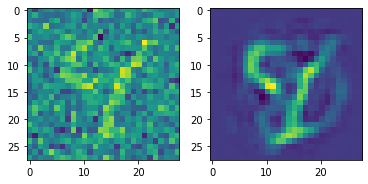

In [ ]:
showEncodeDecode(auto_encode_decode_big, addNoise(test_data_xy[6][0]))

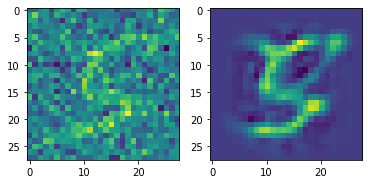

In [ ]:
showEncodeDecode(auto_encode_decode_big, addNoise(test_data_xy[23][0]))

That would seem to indicate that our large auto-encoder with $D'=2\cdot D$ is not very robust! What happens if we apply the same noisy data to our original auto-encoder, which uses $D=2$? You can see that below! The five is reconstructed almost exactly as it was before! A little blurry, but clearly a five. If you run the four through multiple times sometimes you get a "four" back out of the decoder, and sometimes you get something else. 

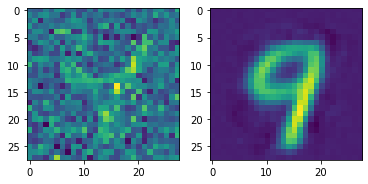

In [ ]:
showEncodeDecode(auto_encode_decode, addNoise(test_data_xy[6][0]))

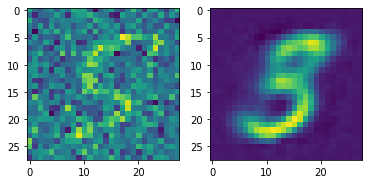

In [ ]:
showEncodeDecode(auto_encode_decode, addNoise(test_data_xy[23][0]))

Based on this experiment, we can see that as we make the encoding dimension $D'$ smaller, the model we learn becomes _more robust_. If we let the encoding dimension become too large, it ma be good at performing reconstructions on easy data, but is not robust to changes and noise. Part of this is because when $D' \geq D$, it becomes easy for the model to learn a simple approach. It has more than enough capacity to just "copy" the input, and learn to regurgitate what it was given. By constraining the model with smaller capacity ($D' \leq D$), the only way it could learn to solve the task is by creating a more compact representation of the input data. Ideally, you would try to find a dimension $D'$ that fits a balance between being able to reconstruct the data well, but using as small an encoding dimension as possible. 

## Denoising Auto Encoders

Making the balance between having $D'$ be small enough to make it robust but large enough to do well at reconstruction is not easy. But there is a trick we can play that will allow us to have large $D' >D $ _and_ learn a robust model! The trick is to create what is called a _denoising_ auto encoder. A denoising auto encoder will add noise to the input of the encoder, while still expecting the decoder to produce the clean image! So our math will go from $\ell(f(\boldsymbol{x}),\boldsymbol{x})$ to $\ell(f(\tilde{\boldsymbol{x}}),\boldsymbol{x})$.  If we do this, there is no naive solution of just "copying" the input, because we have perturbed the input before giving it to the network! So instead the network must learn how to remove the noise, or "de-noise", the input and thus allows us to use $D' >D$ while still obtaining robust representations. 

Denoising networks have a lot of practical usage. If you can make synthetic noise that is realistic to the issues you might see in real life, you can create models that remove that noise and improve the accuracy by making the data cleaner! Libraries like [scikit-image](https://scikit-image.org/) are available with many transforms that can be used to make noisy images, and I've personally used this approach to improve [fingerprint recognition algorithms](https://doi.org/10.1109/ICMLA.2018.00025). 

To do this, we will make only one change to our previous `auto_encoder_big` model. We will add a new layer at the beginning of the encoder sub-network, which adds noise to the input _only when we are training_. The assumption is usually that our training data is relatively clean and prepared, which we are adding noise to to make more robust. If we are then _using_ the model, and no longer training, we want to get the best answer we can --- which means we want the cleanest data possible. Adding noise at that stage would just make our life more difficult, and if the input already had noise we would just be compounding the problem. 

So the first code we need is a new `AdditiveGausNoise` layer which we define below. It takes the input $\boldsymbol{x}$ in and if we are in training mode (denoted by `self.training`) we add noise to the input, otherwise we return it unperturbed! 

In [ ]:
class AdditiveGausNoise(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        #every PyTorch Module object has a self.training boolean which can be used 
        #to check if we are in training (True) or evaluation (False) mode. 
        if self.training:
             return addNoise(x, device=device)
        else:
            return x

Next we will re-define the exact sample large auto encoder as before where $D' = 2 \cdot D$. The only difference is we will insert this `AdditiveGausNoise` layer in early at the start of the network. 

In [ ]:
dnauto_encoder_big = nn.Sequential(
    nn.Flatten(),
    AdditiveGausNoise(),
    nn.Linear(D,  D*2),
    nn.BatchNorm1d(D*2),
    nn.ReLU(),
    nn.Linear(D*2,  D*2),
    nn.BatchNorm1d(D*2),
    nn.ReLU(),
    nn.Linear(D*2,  D*2),
    nn.BatchNorm1d(D*2),
    nn.ReLU(),
    nn.Linear(D*2,  D*2),
)

dnauto_decoder_big = nn.Sequential(
    nn.Linear(D*2,  D*2),
    nn.BatchNorm1d(D*2),
    nn.ReLU(),
    nn.Linear(D*2,  D*2),
    nn.BatchNorm1d(D*2),
    nn.ReLU(),
    nn.Linear(D*2,  D*2),
    nn.BatchNorm1d(D*2),
    nn.ReLU(),
    nn.Linear(D*2,  D),
    View(-1, 1, 28, 28)
)

dnauto_encode_decode_big = nn.Sequential(
    dnauto_encoder_big,
    dnauto_decoder_big
)

Now we can train like normal. 

In [ ]:
train_network(dnauto_encode_decode_big, mse_loss, train_loader, val_loader=test_loader, epochs=10, device=device)

,epoch,total time,train loss,val loss
0,0,9.687227,0.032087,0.019236
1,1,18.782378,0.021034,0.015188
2,2,27.916194,0.018666,0.013636
3,3,37.272913,0.017336,0.012508
4,4,46.578386,0.016727,0.011954
5,5,55.664637,0.015966,0.011100
6,6,64.719028,0.015321,0.010625
7,7,73.722288,0.014727,0.010508
8,8,83.037266,0.014464,0.011438
9,9,91.972981,0.014230,0.009725


So how well does it do? Below we can see the same data reconstructed when there is and is not noise. The new denoising model is clearly the best at creating reconstructions of all the models we have developed so far! In both cases the denoising auto encoder captures most of the style of the individual digits. There are still small details that the denoising approach misses, likely because they are so small the model isn't sure if it is a real part of the style or just part of the noise. For example the flourish on the bottom of the 4 and the top of the 5 is now missing after reconstruction. 

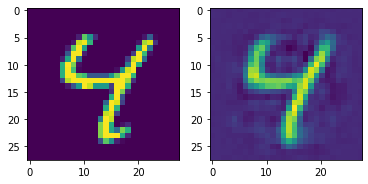

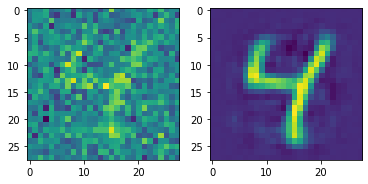

In [ ]:
showEncodeDecode(dnauto_encode_decode_big, test_data_xy[6][0])
showEncodeDecode(dnauto_encode_decode_big, addNoise(test_data_xy[6][0]))

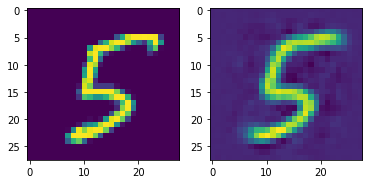

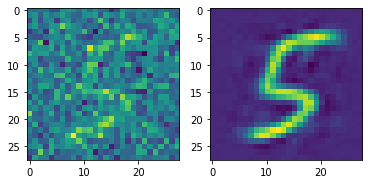

In [ ]:
showEncodeDecode(dnauto_encode_decode_big, test_data_xy[23][0])
showEncodeDecode(dnauto_encode_decode_big, addNoise(test_data_xy[23][0]))

The denoising approach is very popular for training auto-encoders, and the trick of introducing your own perturbations into the data is widely used to build more accurate and robust models. As you learn more about deep learning and different applications, you will find many different forms and spins on this same approach.

Beyond helping learn more robust representations, the denoising approach can itself be a useful model. Noise can naturally occur in many situations. For example, when performing Optical Character Recognition (OCR) to convert an image into searchable text, you can get noise from damage to the camera itself, damage to the document (e.g., water or coffee stains), changes in lighting, objects casting shadows, and an almost innumerable number of random issues that occur in real data. Many OCR systems have thus been improved by learning to add noise that looks like the noise seen in real life, and asking the model to learn in spite of this noise. 

# Autoregressive Models

The auto encoding approach has been very successful for images, signals, and even fully-connected models with tabular data. But what if our data is a sequence problem? Especially if our data is language which is represented by discrete tokens, its hard to add meaningful noise to things like a letter or word. Instead we can use an _autoregressive_ model, which is an approach specifically design for time series problems. 

Lets say your have $t$ steps of your data $\boldsymbol{x}_1, \boldsymbol{x}_2, \ldots, \boldsymbol{x}_{t-1}, \boldsymbol{x}_t$. The goal of an autoregressive model is to predict $\boldsymbol{x}_{t+1}$ given all the previous items in the sequence! The mathy way to write this would be $P(\boldsymbol{x}_{t+1} | \boldsymbol{x}_1, \boldsymbol{x}_2, \ldots, \boldsymbol{x}_t)$. This is still a form of self-supervision, because the next item in a sequence is a trivial component of having the data int he first place! 

The below figure gives an illustration of how autoregressive models  happen at a high level. A sequence based model is shown in the green blocks, and takes in an input $\boldsymbol{x}_i$. The prediction at the $i$'th step is thus $\hat{\boldsymbol{x}}_i$. We then use the loss function $\ell$ to compute the loss between the current prediction $\hat{\boldsymbol{x}}_i$ and the _next input_ $\boldsymbol{x}_{i+1}$, $\ell\left(\hat{\boldsymbol{x}}_i, \boldsymbol{x}_{i+1}\right)$. So for an input with $T$ time steps we will have $T-1$ loss calculations, because the last time step $T$ can't be used as an input because there is no $T+1$'th item to compare it against! 

![Example of an auto-regressive setup. The inputs are at the bottom, and the outputs are at the top. For an input $\boldsymbol{x}_i$ it's prediction from the autoregressive model is $\hat{\boldsymbol{x}}_i$, and the _label_ $\boldsymbol{y}_i = \boldsymbol{x}_{i+1}$.  ](https://drive.google.com/uc?export=view&id=1vB7R0fEbaY0_Om3TqUM7Potd4nxKrl22)

You may have guessed from the look of this diagram that we will be using a recurrent neural network to implement our autoregressive models. This is because RNNs are great for sequence based problems like this one. The big change compared to your previous use of RNNs is that we will be making a prediction at _every_ step, instead of just the _last_ step. 

A type of autoregressive model popularized by [Andrej Karpathy](https://cs.stanford.edu/people/karpathy/) is called _char-RNN_ for "character RNN". This is an autoregressive approach where the inputs/outputs are characters, and well show a simple way to implement a char-RNN model on some Shakespeare data. 

While RNNs are a very appropriate and common architecture to use for autoregressive models, bi-directional RNNs are not! This is because an autoregressive model is making predictions about the future. If we used a bi-directional model we would have information about the future content in the sequence, and knowing the future is cheating! bi-driectional RNNs were a good thing when we wanted to make a prediction about the _whole_ sequence, but now that we are making predictions about the input itself we need to enforce a no bi-directional policy to make sure that our model's do not get to peek at information they should not have. 

## Implementing Char-RNN

The first thing we need is our data! Andrej has shared some text from Shakespear on line that we will download. There are about 100,000 characters in this text so we will store the data in a variable called `shakespear_100k`. 

In [ ]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import re

all_data = []
resp = urlopen("https://cs.stanford.edu/people/karpathy/char-rnn/shakespear.txt")
shakespear_100k = resp.read()
shakespear_100k = shakespear_100k.decode('utf-8').lower()

Now we will build a vocabulary $\Sigma$ of all the characters in this dataset. One change you could make is to not use the `lower()` function to convert everything to lower-case. As we are learning more about deep learning, these early decisions are still important to how our model will eventually be used and how useful it will be. So you should learn to recognize choices like this _as choices_. So I've chosen to have all lower-case data, and so our vocabulary will be smaller. This reduces the difficulty of the task by making the number of options fewer, but means it is impossible for our model to learn about capitalization. 

In [ ]:
vocab2indx = {} #the vocab $\Sigma$
for char in shakespear_100k: 
    if char not in vocab2indx: #add every new character to the vocab
        vocab2indx[char] = len(vocab2indx) #set the index based on the current vocab size

#Some useful code to goe from index back to original characters. 
indx2vocab = {}
#Well simply iterate over all key,value pairs and create a dicionary with the inverse mapping. 
for k, v in vocab2indx.items():
    indx2vocab[v] = k
print("Vocab Size: ", len(vocab2indx))
print("Total Characters:", len(shakespear_100k))

Vocab Size:  36
Total Characters: 99993


Now we are going to take a very simple approach to building an autoregressive dataset. We have the original 100k characters are one giant long sequence, since it is taken from one of Shakespeare's plays. If we break this up into "chunks" that are sufficiently long, we can almost guarantee that each chunk will contain a few complete sentences. So each chunk is obtained by indexing into a position `start` and grabbing a slice of the text `[start:start+chunk_size]`. Since it is autoregressive, our _labels_ are the tokens starting one character over. This can be done by grabbing a new slice shifted by one, so code that looks like `[start+1:start+1+chunk_size]`. 

The below code uses this strategy to implement the Autoregressive dataset. While we are giving our model the difficult of having to learn _starting at a random position that is probably part of the way into a word_, it makes it very easy for us to implement all of the code!

In [ ]:
class AutoRegressiveDataset(Dataset):
    """
    Creates an autoregressive dataset from one single, long, source sequence by breaking it up into "chunks". 
    """

    def __init__(self, large_string, MAX_CHUNK=500):
        """
        large_string: the original long source sequence that chunks will be extracted from
        MAX_CHUNK: the maximum allowed size of any chunk. 
        """
        self.doc = large_string
        self.MAX_CHUNK = MAX_CHUNK

    def __len__(self):
        #The number of items is the number of characters divided by chunk size
        return (len(self.doc)-1) // self.MAX_CHUNK

    def __getitem__(self, idx):
        #Compute the starting position for the idx'th chunk
        start = idx*self.MAX_CHUNK
        #Grab the input sub-string
        sub_string = self.doc[start:start+self.MAX_CHUNK]
        #convert the sub-string into integers based on our vocab
        x = [vocab2indx[c] for c in sub_string]
        
        #grab the label sub-string by shifting over by 1
        sub_string = self.doc[start+1:start+self.MAX_CHUNK+1]
        #convert the label sub-string into integers based on our vocab
        y = [vocab2indx[c] for c in sub_string]
        #convert the 
        return torch.tensor(x, dtype=torch.int64), torch.tensor(y, dtype=torch.int64)

Now comes the tricky part. Implementing an autoregressive RNN model. For this I'm going to use a `GRU` instead of an LSTM because the code will be a little easier to read since the `GRU` has only the hidden states $\boldsymbol{h}_t$ and does not have any context states $\boldsymbol{c}_t$. The high level strategy for our implementation is in the below figure and caption. 

![Autoregressive RNN design. The input is in orange, were an `nn.Embedding` layer will convert each character into a vector. These vectors are feed into an RNN layer shown in green, which will sequentially process each character. Then a set of fully-connected layers will process each RNN hidden state $\boldsymbol{h}_t$ _independently_ (via weight sharing) to make a prediction about the next token.  ](https://drive.google.com/uc?export=view&id=1-OH6RDuPB6__oApcQivNFefIBw6DsMlm)


### Construction

Our constructor will take in some familiar arguments. We want to know the size of the vocabulary `num_embeddings`, how many dimensions for the embedding layer `embd_size`, the number of neurons in each hidden layer `hidden_size`, and the number of RNN layers `layers=1`. So our code will start with:

```python
class AutoRegressive(nn.Module):

    def __init__(self, num_embeddings, embd_size, hidden_size, layers=1):
        super(AutoRegressive, self).__init__()
        self.padding_idx = padding_idx
        self.hidden_size = hidden_size
        self.embd = nn.Embedding(num_embeddings, embd_size)
```

Now our first major change to our architecture is that we are not going to use the normal `nn.GRU`  module. The normal `nn.RNN`, `nn.LSTM`, and `nn.GRU` modules take in _all_ time steps at once and return _all outputs_ at once. You can use these to implement an autoregressive model, but we are instead going to use the `nn.GRUCell` module. The `GRUCell` processes sequences _one item at a time_. This makes them slower, but can make it easier to handle inputs with an unknown and variable length. This will be useful once we are done training the model, but I don't want to ruin the surprise! So we will come back to _why_ we are doing it this way in a moment. 

So if we want to have multiple `layers` of an RNN, we are going to have to manually specify and run them ourselves. We can do this by using a `ModuleList` to specify multiple modules in a group. This means our initializationn code after `self.embd` will look like:

```python
self.layers = nn.ModuleList([nn.GRUCell(embd_size, hidden_size)] + 
    [nn.GRUCell(hidden_size, hidden_size) for i in range(layers-1)])
self.norms = nn.ModuleList(
    [nn.LayerNorm(hidden_size) for i in range(layers)])
```

We broke up the specification of `GRUCell` layers into two parts. First a list of one item for the first layer since it has to go from `embd_size` inputs to `hidden_size` outputs. Second is all remaining layers with `[nn.GRUCell(hidden_size, hidden_size) for i in range(layers-1)]` which works because each of these layers has the same input and output size. For fun I've also included a `LayerNorm` normalization layer for each RNN result. 

The last thing we need in our constructor is the purple layers that take in the hidden states $\boldsymbol{h}_t$ and outputs a prediction for the class. This is done with a small fully connected network that looks like:
```python
self.pred_class = nn.Sequential(
    nn.Linear(hidden_size, hidden_size),# (B, *, D)
    nn.LeakyReLU(),
    nn.LayerNorm(hidden_size), # (B, *, D)
    #(B, *, D) -> B(B, *, VocabSize)
    nn.Linear(hidden_size, num_embeddings) 
)
```

Notice that I've defined a component of this module as an entire network! This will help us compartmentalize our design and make our code easier to read. Now if you ever want to go back and change the sub-network that goes from hidden RNN states to predictions, you can change just the `pred_class` object, and the rest of the code will work just fine! 

### The Forward Step

Our `forward` function of the module is going to "organize" the work  done by two other helper functions. First we will  embed all of the input tokens into their vector forms, as this can all be done at once. Because we are using a `GRUCell` class, we need to keep track of the hidden states ourselves. So we will use a `initHiddenStates(B)` function that will create the initial hidden states $\boldsymbol{h}_0 = \vec{0}$ for each GRU layer. Then we will use a `for` loop to grab each of the $t$ items and process them one "step" at a time using a `step` function which takes in the inputs $\boldsymbol{x}_t$ and a list of the GRU hidden states `h_prevs`. This will be stored in a list `last_activations` to get the predictions at every time step. Finally we can return a single tensor by `stack`ing the results together. 

```python
def forward(self, input):
    #Input should be (B, T)
    #What is the batch size?
    B = input.size(0)
    #What is the max number of time steps?
    T = input.size(1)

    x = self.embd(input) #(B, T, D)

    #Initial hidden states
    h_prevs = self.initHiddenStates(B)

    last_activations = []
    for t in range(T):
        x_in = x[:,t,:] #(B, D)
        last_activations.append(self.step(x_in, h_prevs))

    last_activations = torch.stack(last_activations, dim=1) 
    #(B, T, D)

    return last_activations
```

The `initHiddenStates` is easy to implement. We can use the `torch.zeros` function to create a tensor of all zero values. We just have the argument `B` for how large the batch is, and then we can grab the `hidden_size` and number of `layers` from the object's members. 

```python
def initHiddenStates(self, B):
    """
    Creates an initial hidden state list for the RNN layers. 

    B: the batch size for the hidden states. 
    """
    return [torch.zeros(B, self.hidden_size, device=device) 
            for _ in range(len(self.layers))]
```

The `step` function is a little more involved. First we will check the shape of the input, and if it has only one dimension we assume that we need to embed the token values to make vectors. Then we check the hidden sates `h_prevs` and if not provided, initialize them using `initHiddenStates`. These are both good defensive code steps to make sure our function can be versatile and avoid errors. 

```python
def step(self, x_in, h_prevs=None):
    """
    x_in: the input for this current time step and has shape (B) 
        if the values need to be embedded, and (B, D) if they 
        have alreayd been embedded. 
    h_prevs: a list of hidden state tensors each with shape 
        (B, self.hidden_size) for each layer in the network. 
        These contain the current hidden state of the RNN layers
        and will be updated by this call. 
    """
    #Prep all three arguments to be in the final form
    if len(x_in.shape) == 1: #(B), we need to embed it
        x_in = self.embd(x_in) #now (B, D)

    if h_prevs is None:
        h_prevs = self.initHiddenStates(x_in.shape[0])

    #Process the input 
    for l in range(len(self.layers)):
        h_prev = h_prevs[l]
        #push in the current input with previous hidden states
        h = self.norms[l](self.layers[l](x_in, h_prev))

        h_prevs[l] = h
        x_in = h
    #Make predictions about the token
    return self.pred_class(x_in)
```

After those defensive coding steps, we simply loop through the number of layers and process the results. `x_in` will be the input to a layer, which gets passed into the current layer `self.layers[l]` and then the normalization layer `self.norms[l]`. After that we do the minor book keeping of storing the new hidden state `h_prevs[l] = h` and setting `x_in = h` so that the next layer has it's input read-to-process. Once that loops is done `x_in` will have the result from the last RNN layer, and so we can feed it directly to `self.pred_class` object to go from RNN hidden state to a prediction about the next character. 

In [ ]:
class AutoRegressive(nn.Module):

    def __init__(self, num_embeddings, embd_size, hidden_size, layers=1):
        super(AutoRegressive, self).__init__()
        self.hidden_size = hidden_size
        self.embd = nn.Embedding(num_embeddings, embd_size)
        self.layers = nn.ModuleList([nn.GRUCell(embd_size, hidden_size)] + 
                                     [nn.GRUCell(hidden_size, hidden_size) for i in range(layers-1)])
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_size) for i in range(layers)])
        
        self.pred_class = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),# (B, *, D)
            nn.LeakyReLU(),
            nn.LayerNorm(hidden_size), # (B, *, D)
            nn.Linear(hidden_size, num_embeddings) #(B, *. D) -> B(B, *, VocabSize)
        )
        
    def initHiddenStates(self, B):
        """
        Creates an initial hidden state list for the RNN layers. 
        
        B: the batch size for the hidden states. 
        """
        return [torch.zeros(B, self.hidden_size, device=device) for _ in range(len(self.layers))]
        
    def step(self, x_in, h_prevs=None):
        """
        x_in: the input for this current time step and has shape (B) if the values need 
            to be embedded, and (B, D) if they have alreayd been embedded. 

        h_prevs: a list of hidden state tensors each with shape (B, self.hidden_size) for each 
            layer in the network. These contain the current hidden state of the RNN layers and 
            will be updated by this call. 
        """
        #Prep all three arguments to be in the final form
        if len(x_in.shape) == 1: #(B), we need to embed it
            x_in = self.embd(x_in) #now (B, D)

        if h_prevs is None:
            h_prevs = self.initHiddenStates(x_in.shape[0])
        
        #Process the input 
        for l in range(len(self.layers)):
            h_prev = h_prevs[l]
            h = self.norms[l](self.layers[l](x_in, h_prev))

            h_prevs[l] = h
            x_in = h
        #Make predictions about the token
        return self.pred_class(x_in)
    
    def forward(self, input):
        #Input should be (B, T)
        #What is the batch size?
        B = input.size(0)
        #What is the max number of time steps?
        T = input.size(1)
        
        x = self.embd(input) #(B, T, D)
        
        #Initial hidden states
        h_prevs = self.initHiddenStates(B)
        
        last_activations = []
        for t in range(T):
            x_in = x[:,t,:] #(B, D)
            last_activations.append(self.step(x_in, h_prevs))
        
        last_activations = torch.stack(last_activations, dim=1) #(B, T, D)
        
        return last_activations

You make also notice that I have a new comment in this code about the tensor shapes with `# (B, *, D)`. This is because `nn.Linear` layers have a special trick that allows them to be applied to multiple inputs _independently_ a the same time! We have always used a linear model over a tensor with shape $(B, D)$, and the linear model can take in $D$ inputs and return $D'$ outputs. So we would go from $(B, D) \to (B, D')$. If we have $T$ items like in a sequence, we have a tensor of shape $(B, T, D)$. Applying a linear model to _each_ time step naively would require a `for` loop and look like:
```python
def applyLinearLayerOverTime(x):
    results = [] #Place to store result for each step
    B, T, D = x.shape
    for t in range(T):
        #get result for each step
        results.append(linearLayer(x[:,t,:])
    #stack everything into one tensor and shape it correctly
    return torch.stack(results, dim=0).view(B, T, -1)
```
Now that is more code than we would like, _and_ it will run slower because of the `for` loop. PyTorch has a simple trick that `nn.Linear` layers are applied to the _last_ axis of a tensor _regardless of the number of axes_. That means this whole function can be replaced with just `linearLayer` and you will get the _exact same result_. That is less code _and_ faster! This way any fully connected network can be used on single time steps, or groups of time steps, without having to do anything special! Still, its good to keep comments like `# (B, D)` and `#(B, T, D)` so that you can remind yourself _how_ you are using your networks. 

With our model defined we are almost done. Below we will quickly create our new `AutoRegressiveDataset` wit the `shakespear_100k` data as the input, and well make a data loader using a respectable batch size. We will also create our `AutoRegressive` model with 32 dimensions for the embedding, 128 hidden neurons, and 2 GRU layers. We will also include gradient clipping because RNNs are sensitive to that issue. 

In [ ]:
autoRegData = AutoRegressiveDataset(shakespear_100k, MAX_CHUNK=250)
autoReg_loader = DataLoader(autoRegData, batch_size=128, shuffle=True)

In [ ]:
autoReg_model = AutoRegressive(len(vocab2indx), 32, 128, layers=2)
autoReg_model = autoReg_model.to(device)

for p in autoReg_model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -2, 2))

The last thing we need is a loss function $\ell$. We are making a prediction at every step, so we want to use the `CrossEntropyLoss` that is appropriate for classification problems. _However_ we have _multiple_ losses to compute, one for every time step! We can solve this by writing our own loss function `CrossEntLossTime` that will compute the cross entropy for each step. Similar to our `forward` function above, we will just slice each prediction `x[:,t,:]` and a corresponding label `y[:t]` so that we end up the standard $(B, C)$ and $(B)$ shapes for the prediction and labels respectively, so that we can just cal `CrossEntropyLoss` directly. Then we add the losses from every time step to get a single total loss to return. 

In [ ]:
def CrossEntLossTime(x, y):
    """
    x: output with shape (B, T, V)
    y: labels with shape (B, T)
    
    """
    cel = nn.CrossEntropyLoss()
    
    T = x.size(1)
    
    loss = 0
    
    for t in range(T):
        loss += cel(x[:,t,:], y[:,t])
    
    return loss

Now we can finally train our autoregressive model! We use our same `train_network` function but pass in our new `CrossEntLossTime` function as the loss function $\ell$ and everything will just work! 

In [ ]:
train_network(autoReg_model, CrossEntLossTime, autoReg_loader, epochs=100, device=device)

,epoch,total time,train loss
0,0,2.027826,883.691422
1,1,3.806508,791.777023
2,2,5.664296,770.138016
3,3,7.559635,762.738617
4,4,9.384403,760.864456
...,...,...,...
95,95,174.709865,393.246017
96,96,176.510964,393.227577
97,97,178.278239,391.849052
98,98,180.063190,393.121910


## Autoregressive Models Are Generative Models

We saved one last detail for the end because its easier to _see_ it and it is to explain. Autoregressive models are not only self-supervised, but they also fall into a class known as _generative_ models. This means that they can _generate_ new data that looks like the original data it was trained on! To do this we will switch our model to `eval` mode and create a tensor `sampling` that will store our generated output. Any a output that is generated from a model can be called a "sample" and the process of generating that sample is called "sampling" if you want to sound cool, and is good terminology for your to remember. 

In [ ]:
autoReg_model = autoReg_model.eval()
sampling = torch.zeros((1, 500), dtype=torch.int64, device=device)

To sample from an autoregressive model we usually need to give the model a "seed". This is some original text that the model is _given_ and then the model is asked to make predictions about what comes next! The code for setting a seed is below, where "EMILIA:" is our initial seed, as if the character Emilia is about to speak in the play. 

In [ ]:
seed = "EMILIA:".lower()
cur_len = len(seed)
sampling[0,0:cur_len] = torch.tensor([vocab2indx[x] for x in seed])

The sampling process of an autoregressive model is shown in the below figure. Our "seed" is passed in as the initial inputs ti the model, and we _ignore_ the predictions being made. This is because our seed is helping to build the hidden  states $\boldsymbol{h}$ of the the RNN which contain information about every previous input. Once we have proceed the entire seed, we have no more inputs. So once the seed has run out of inputs, we use the _previous_ output of the model $\hat{\boldsymbol{x}}_t$ as the _input_ for the next time step $t+1$. This is possible because the autoregressive model has _learned to predict what comes next_. If it does a good job at this, it's predictions can be used as inputs, and we end up _generating_ new sequences in the process! 

![A seed of "Seed" is given to the model, and we ignore the predictions being made. Once the seed runs out, we use the predictions at time step $t$ as the input to the next step $t+1$. ](https://drive.google.com/uc?export=view&id=16v1Tx5OmDJsmtaLwH5K9kIDpcfnqlCoA)

But how exactly do we use a prediction as an input? Our model's making a prediction about the probability of seeing _every_ different character as the next possible output. But the next input needs to be a _specific_ character. This can be done by _sampling_ the predictions based on the model's output probabilities. So if the character "a" has a 100% prediction of being next, the model _will_ return "a". If instead we have 80% "a", 10% "b", and 10% "c", then we will _probably_ select "a" as the next class but we could pick "b" or "c" too. The below code will doe just that!

In [ ]:
for i in tqdm(range(cur_len, sampling.size(1))):
    with torch.no_grad():
        h = autoReg_model(sampling[:,0:i]) #process all the previous items
        h = h[:,-1,:] #Grab the last time step
        h = F.softmax(h, dim=1) #make probabilities
        next_tokens = torch.multinomial(h, 1) #sample the next prediction
        sampling[:,i] = next_tokens #set the next prediction
        #increase the length by one
        cur_len += 1

Now we have a new sequence that we have predicted, but what does it look like? That is why we saved an _inverse mapping_ from tokens back to our vocabulary with the `indx2vocab` `dict`. So we can use that to map each integer back to a character, and then `join` them together to create an output! So below will convert our generative sample back into text we can read! 

In [ ]:
s = [indx2vocab[x] for x in sampling.cpu().numpy().flatten()]
print("".join(s))

emilia:
to hen fire upot tractast of nor wand,
good were your good mine.

norfold:
i vanour a gooding in his sing.

hatm: i speak ofservant:
there tanmys you, of with my eneed.

sey duchings,
bur, put serving our noblenous.

prove lord:
for the pome, lardel'd,
moul'd make a wither, were
worsy mines?

tre brond,
i must soon i denerity peauty,
while not ciscey put hast plesseer our mory hand
poir lurptien stuch a man bead:
and thisuest you!.

norfolk:
lord, with sold as i bedy cars not do
throwes 


You should notice a few things about the output of our generation. While it kinda looks Shakespearian it seems to quickly devolve. This is because with each step of the data we get farther away from _real_ data, and our model _will_ make unrealistic choices that thus become errors, and negatively impact future predictions. So the longer we generate the lower the quality will become. 

A second issue is that sampling the next character based on the predicted probabilities is giving lots of opportunities for more errors. If you are 99% sure that the next character should be an "a", why give the model the 1% opportunity to pick something that is likely wrong? To encourage the model to go with the most likely predictions we can add a _temperature_ to the generation process. The `temperature` will be a scalar that we dive the model's prediction by before computing the `softmax` to make probabilities. This way a `temperature < 1` will give large values a bigger advantage, and increase their probability. If we make `temperature > 1` we end up giving lower probabilities items more of a chance to be selected. In practice a value of 0.75 is a good default. THe below code adds the temperature to the sampling process. 

In [ ]:
cur_len = len(seed)
temperature = 0.75
for i in tqdm(range(cur_len, sampling.size(1))):
    with torch.no_grad():
        h = autoReg_model(sampling[:,0:i])
        h = h[:,-1,:] #Grab the last time step
        h = F.softmax(h/temperature, dim=1) #make probabilities
        next_tokens = torch.multinomial(h, 1)
        sampling[:,i] = next_tokens

        cur_len += 1

Now if we print out our predictions we should see something that "feels" a little more reasonable. It will is not perfect, and a bigger model with more epochs of training can help improve that. But adding a `temperature` is a common trick to help control the generation process. 

In [ ]:
s = [indx2vocab[x] for x in sampling.cpu().numpy().flatten()]
print("".join(s))

So you may be thinking, why not lower the temperature even further? Should we not _always_ want to go with the most likely prediction? This gets to some deep issues about the difficulty of evaluating generative and autoregressive models. Especially when the input is something like human text, which is not all that predictable to begin with. If I told you I could _perfectly_ predict what someone was going to say, you would likely be incredulous. How could that be possible? We should always apply that same standard to our model. If we _always_ select the most likely prediction, we are assuming the model can _perfectly_ predict what a person would say next. We can try that out by setting the temperature to a very ow value like 0.5. The below code does that. 

In [ ]:
cur_len = len(seed)
temperature = 0.05
for i in tqdm(range(cur_len, sampling.size(1))):
    with torch.no_grad():
        h = autoReg_model(sampling[:,0:i])
        h = h[:,-1,:] #Grab the last time step
        h = F.softmax(h/temperature, dim=1) #make probabilities
        next_tokens = torch.multinomial(h, 1)
        sampling[:,i] = next_tokens

        cur_len += 1
s = [indx2vocab[x] for x in sampling.cpu().numpy().flatten()]
print("".join(s))

You should see that the model has become _very_ repetitive! This is what usually happens when you select the most likely token as the next one, the model devolves to selecting a sequence of the most common words/tokens over and over and over again. 

## Faster Sampling

You may have noticed that the sampling process takes a surprisingly long time. About 45-50 seconds to generate 500 characters, yet we were able to train over 100k characters in just seconds per epoch!  This is because each time we make a prediction, we needed to re-feed the entire generated sequence so far back into the model to get the next prediction. Using big-O notation that means we are doing $O(n^2)$ work to generate a sequence of $O(n)$ length. 

The `GRUCell` that processes sequences one step at a time makes it easy for us to solve this problem. We will break our `for` loop up into two parts, each using the `step` function directly instead of the `forward` function of the module. The first loop will push the seed into the model, updating an explicitly created set of hidden states `h_prevs`. After that we can write a new loop that generates the new content and calls the `step` function to update the model after sampling the next character. This process is shown in the below code. 

In [ ]:
#Set up our seed and the location to store the generated content
seed = "EMILIA:".lower()
cur_len = len(seed)
sampling = torch.zeros((1, 500), dtype=torch.int64, device=device)
sampling[0,0:cur_len] = torch.tensor([vocab2indx[x] for x in seed])

#pick a temperature
temperature = 0.75
with torch.no_grad():
    #initialize the hidden state to avoid redundant work
    h_prevs = autoReg_model.initHiddenStates(1)
    #push the seed through
    for i in range(0, cur_len):
        h = autoReg_model.step(sampling[:,i], h_prevs=h_prevs)

    #generate new text one character at a time
    for i in tqdm(range(cur_len, sampling.size(1))):
        h = F.softmax(h/temperature, dim=1) #make probabilities
        next_tokens = torch.multinomial(h, 1)
        sampling[:,i] = next_tokens
        cur_len += 1
        #now push only the new sample into the model
        h = autoReg_model.step(sampling[:,i], h_prevs=h_prevs)

You may have notices that this new code ran in less than a second! This is much faster and gets faster the longer the sequence we want to generate, because it has a better big-O complexity of $O(n)$ to generate $O(n)$ tokens. Below we print out the generated result and you can see that its qualitatively the same as before. 

In [ ]:
s = [indx2vocab[x] for x in sampling.cpu().numpy().flatten()]
print("".join(s))

# Summary

In this chapter we have learned about the concept of self-supervision as a means of training a neural network by using parts of the input _as the labels_ that we are trying to predict! Self-supervision is considered unsupervised because it can be applied to any data, and does not require any kind or process or human to manually label the data.  Auto-encoding is one of the most popular forms of self-supervision that works by having the network literally predict the input as the output, but somehow constrains the network so that it can not naively return the original input. This constraint is often either a "bottleneck" design that forces the dimension to shrink before expanding back out, or a "denoising" approach where the input is altered before being given to the network, but the network still must predict the unaltered output. If we have a sequence problem we can instead use autoregressive models which look at every previous input in a sequence to predict the next input. Autoregressive approaches have the benefit of being _generative_, which means we can create synthetic data from the model! 

# Homework

1. By October 21st email me with the subject "DATA 690 Fall 2020: Project Teamate" with who your project teammate is. Both team members must send this email. If you do not have a team member say so. 
2. I will pair people without a project by October 23rd. 
3. By October 28th you must send me an email as a team (1 email) with the subject "DATA 690 Fall 2020: Project Idea" with your plan for your project. I will provide feedback if I think the project is too ambitious or does not have enough work. 